# Evaluación de Modelos de Aprendizaje Automático - Implementación Práctica

**Objetivo:** Aplicar la metodología de evaluación multidimensional al modelo de predicción de churn desarrollado en el ejercicio 1.

**Nota:** La investigación teórica completa se encuentra en el documento "Investigacion_Evaluacion_Modelos_ML.md"


In [20]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

print("=== EVALUACIÓN INTEGRAL DEL MODELO DE CHURN ===")
print("Aplicando la metodología de evaluación multidimensional\n")


=== EVALUACIÓN INTEGRAL DEL MODELO DE CHURN ===
Aplicando la metodología de evaluación multidimensional



## 1. Carga y Preparación de Datos


In [21]:
# Cargar datos
df = pd.read_csv("datos_churn.csv")
print(" ANÁLISIS EXPLORATORIO DE DATOS")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Distribución de churn: \n{df['churn'].value_counts()}")
print(f"Proporción de churn: {df['churn'].mean():.3f}")

# Preparar datos
X = df.drop(columns=["churn"])
y = df["churn"]

# Definir columnas numéricas y categóricas
num_cols = ["tenure_meses", "tarifa_mensual", "horas_uso_semana", "dispositivos_vinculados", "tickets_soporte_90d"]
cat_cols = ["autopago", "recibio_promo", "region"]

# Crear pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

# Modelo
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=200, class_weight="balanced", random_state=42))
])


 ANÁLISIS EXPLORATORIO DE DATOS
Dimensiones del dataset: (1000, 9)
Distribución de churn: 
churn
0    969
1     31
Name: count, dtype: int64
Proporción de churn: 0.031


## 2. Dimensión 1: Evaluación de Rendimiento Predictivo


In [22]:
print("\n DIMENSIÓN 1: RENDIMIENTO PREDICTIVO")
print("="*50)

# División de datos con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Datos de entrenamiento: {X_train.shape[0]} muestras")
print(f"Datos de prueba: {X_test.shape[0]} muestras")

# Entrenamiento
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Métricas básicas
print(f"\n MÉTRICAS DE CLASIFICACIÓN:")
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisión (Precision): {precision_score(y_test, y_pred):.4f}")
print(f"Sensibilidad (Recall): {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Matriz de confusión
print(f"\n MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Interpretación de la matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nInterpretación:")
print(f"• Verdaderos Negativos (TN): {tn} - Clientes que NO harán churn y fueron clasificados correctamente")
print(f"• Falsos Positivos (FP): {fp} - Clientes que NO harán churn pero fueron marcados como churn")
print(f"• Falsos Negativos (FN): {fn} - Clientes que SÍ harán churn pero no fueron identificados")
print(f"• Verdaderos Positivos (TP): {tp} - Clientes que SÍ harán churn y fueron identificados correctamente")



 DIMENSIÓN 1: RENDIMIENTO PREDICTIVO
Datos de entrenamiento: 750 muestras
Datos de prueba: 250 muestras

 MÉTRICAS DE CLASIFICACIÓN:
Exactitud (Accuracy): 0.7240
Precisión (Precision): 0.0448
Sensibilidad (Recall): 0.3750
F1-Score: 0.0800
AUC-ROC: 0.6689

 MATRIZ DE CONFUSIÓN:
[[178  64]
 [  5   3]]

Interpretación:
• Verdaderos Negativos (TN): 178 - Clientes que NO harán churn y fueron clasificados correctamente
• Falsos Positivos (FP): 64 - Clientes que NO harán churn pero fueron marcados como churn
• Falsos Negativos (FN): 5 - Clientes que SÍ harán churn pero no fueron identificados
• Verdaderos Positivos (TP): 3 - Clientes que SÍ harán churn y fueron identificados correctamente


## 3. Dimensión 2: Robustez y Generalización



 DIMENSIÓN 2: ROBUSTEZ Y GENERALIZACIÓN
**************************************************
 VALIDACIÓN CRUZADA (5-fold):
AUC promedio: 0.7298 ± 0.1369
Rango: [0.5586, 0.9435]


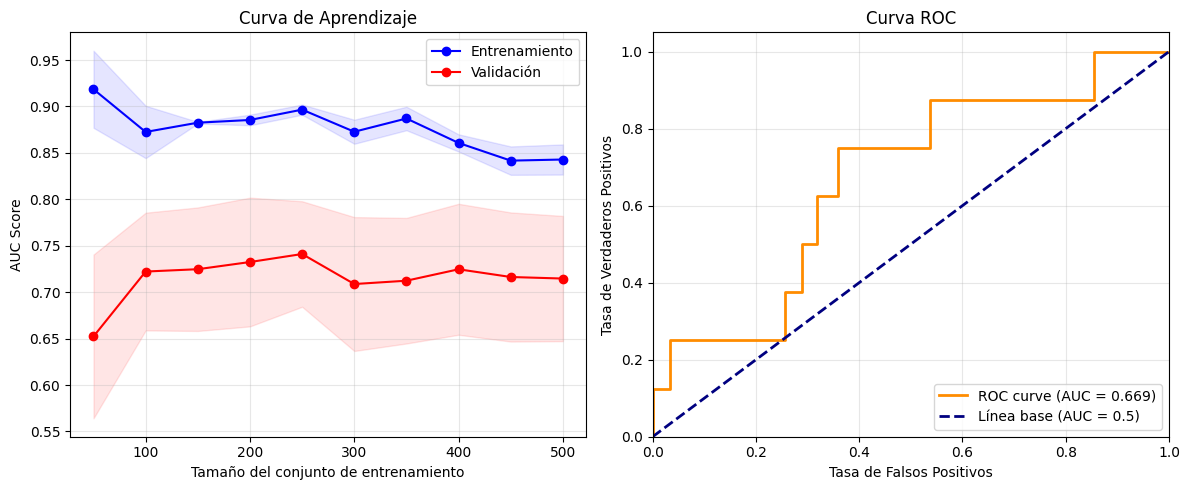


ANÁLISIS POR SEGMENTOS:
AUC en Occidente: 0.6509 (n=55)
AUC en Norte: 0.7910 (n=71)
AUC en Centro: 1.0000 (n=68)
AUC en Sur: 0.9636 (n=56)


In [23]:
print("\n DIMENSIÓN 2: ROBUSTEZ Y GENERALIZACIÓN")
print("*"*50)

# Validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f" VALIDACIÓN CRUZADA (5-fold):")
print(f"AUC promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc'
)

plt.figure(figsize=(12, 5))

# Subplot 1: Curva de aprendizaje
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Entrenamiento', color='blue')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validación', color='red')
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1, color='red')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('AUC Score')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Curva ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea base (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de estabilidad por segmentos
print(f"\nANÁLISIS POR SEGMENTOS:")
for region in df['region'].unique():
    mask = X_test['region'] == region
    if mask.sum() > 0:
        auc_region = roc_auc_score(y_test[mask], y_pred_proba[mask])
        print(f"AUC en {region}: {auc_region:.4f} (n={mask.sum()})")


## 4. Dimensión 3: Interpretabilidad y Explicabilidad



DIMENSIÓN 3: INTERPRETABILIDAD Y EXPLICABILIDAD
**************************************************
 IMPORTANCIA DE CARACTERÍSTICAS:
            caracteristica  coeficiente  odds_ratio  importancia_abs
7             region_Norte      -1.8571      0.1561           1.8571
5               autopago_1      -1.3360      0.2629           1.3360
6          recibio_promo_1      -1.3316      0.2641           1.3316
8         region_Occidente      -0.8740      0.4173           0.8740
4      tickets_soporte_90d       0.6572      1.9294           0.6572
0             tenure_meses      -0.5519      0.5759           0.5519
2         horas_uso_semana      -0.3963      0.6728           0.3963
1           tarifa_mensual       0.2515      1.2859           0.2515
9               region_Sur      -0.1991      0.8195           0.1991
3  dispositivos_vinculados      -0.1389      0.8703           0.1389


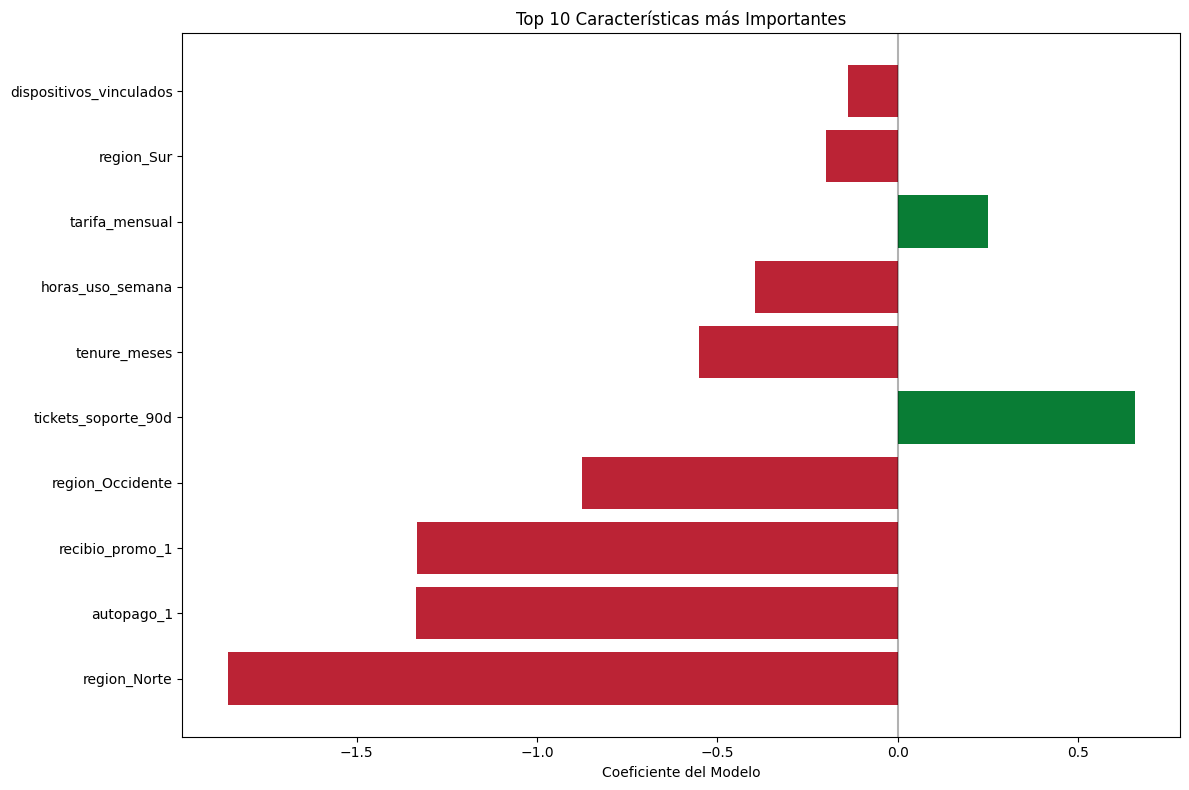


 INTERPRETACIÓN DE COEFICIENTES:
• Coeficientes positivos (verde) → AUMENTAN la probabilidad de churn
• Coeficientes negativos (rojo) → DISMINUYEN la probabilidad de churn

Factores que MÁS aumentan el riesgo de churn:
  - tickets_soporte_90d: OR = 1.929
  - tarifa_mensual: OR = 1.286

Factores que MÁS reducen el riesgo de churn:
  - region_Norte: OR = 0.156
  - autopago_1: OR = 0.263
  - recibio_promo_1: OR = 0.264


In [29]:
print("\nDIMENSIÓN 3: INTERPRETABILIDAD Y EXPLICABILIDAD")
print("*"*50)

# Obtener nombres de características después del preprocesamiento
feature_names = (num_cols +
                list(model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(cat_cols)))

# Coeficientes del modelo
coefficients = model.named_steps['classifier'].coef_[0]

# Crear DataFrame con importancia de características
feature_importance = pd.DataFrame({
    'caracteristica': feature_names,
    'coeficiente': coefficients,
    'odds_ratio': np.exp(coefficients),
    'importancia_abs': np.abs(coefficients)
}).sort_values('importancia_abs', ascending=False)

print(" IMPORTANCIA DE CARACTERÍSTICAS:")
print(feature_importance.round(4))

# Visualización de importancia
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)

plt.barh(range(len(top_features)), top_features['coeficiente'])
plt.yticks(range(len(top_features)), top_features['caracteristica'])
plt.xlabel('Coeficiente del Modelo')
plt.title('Top 10 Características más Importantes')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Añadir interpretación con colores
colors = ['red' if x < 0 else 'green' for x in top_features['coeficiente']]
bars = plt.barh(range(len(top_features)), top_features['coeficiente'], color=colors, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\n INTERPRETACIÓN DE COEFICIENTES:")
print("• Coeficientes positivos (verde) → AUMENTAN la probabilidad de churn")
print("• Coeficientes negativos (rojo) → DISMINUYEN la probabilidad de churn")
print("\nFactores que MÁS aumentan el riesgo de churn:")
for _, row in feature_importance[feature_importance['coeficiente'] > 0].head(3).iterrows():
    print(f"  - {row['caracteristica']}: OR = {row['odds_ratio']:.3f}")

print("\nFactores que MÁS reducen el riesgo de churn:")
for _, row in feature_importance[feature_importance['coeficiente'] < 0].head(3).iterrows():
    print(f"  - {row['caracteristica']}: OR = {row['odds_ratio']:.3f}")


## 5. Dimensión 4: Eficiencia Computacional



DIMENSIÓN 4: EFICIENCIA COMPUTACIONAL
**************************************************
 TIEMPOS DE EJECUCIÓN:
Tiempo de entrenamiento: 0.0108 segundos
Tiempo de predicción: 0.0027 segundos
Predicciones por segundo: 91236


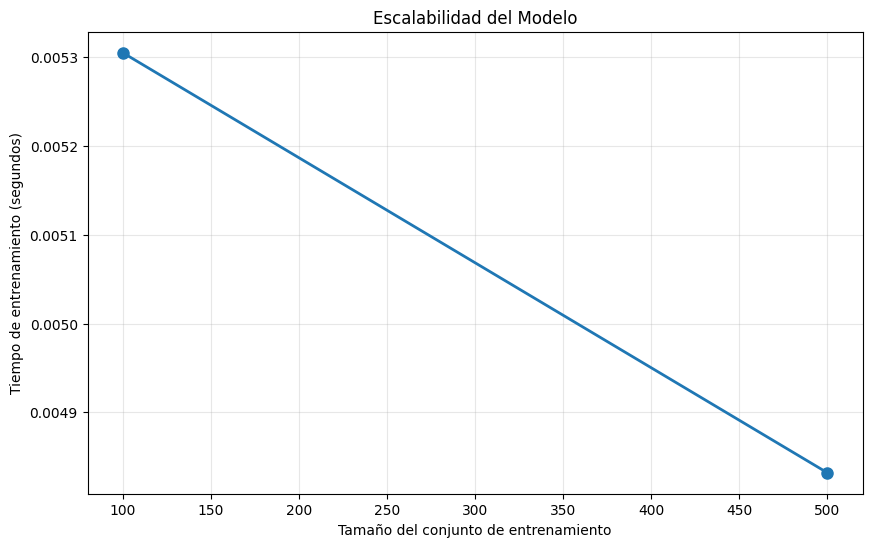

COMPLEJIDAD COMPUTACIONAL:
El modelo muestra escalabilidad lineal


In [30]:
print("\nDIMENSIÓN 4: EFICIENCIA COMPUTACIONAL")
print("*"*50)

# Medir tiempo de entrenamiento
start_time = time.time()
model_timing = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=200, class_weight="balanced", random_state=42))
])
model_timing.fit(X_train, y_train)
training_time = time.time() - start_time

# Medir tiempo de predicción
start_time = time.time()
predictions = model_timing.predict(X_test)
prediction_time = time.time() - start_time

print(f" TIEMPOS DE EJECUCIÓN:")
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print(f"Tiempo de predicción: {prediction_time:.4f} segundos")
print(f"Predicciones por segundo: {len(X_test)/prediction_time:.0f}")

# Análisis de escalabilidad
sizes = [100, 500, 1000, 2000]
training_times = []

for size in sizes:
    if size <= len(X_train):
        X_sample = X_train.sample(n=size, random_state=42)
        y_sample = y_train.loc[X_sample.index]

        start_time = time.time()
        temp_model = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=200, class_weight="balanced", random_state=42))
        ])
        temp_model.fit(X_sample, y_sample)
        training_times.append(time.time() - start_time)

plt.figure(figsize=(10, 6))
plt.plot(sizes[:len(training_times)], training_times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Tiempo de entrenamiento (segundos)')
plt.title('Escalabilidad del Modelo')
plt.grid(True, alpha=0.3)
plt.show()

print(f"COMPLEJIDAD COMPUTACIONAL:")
print(f"El modelo muestra escalabilidad {'lineal' if len(training_times) > 1 and training_times[-1]/training_times[0] < 10 else 'no lineal'}")


## 6. Dimensión 5: Consideraciones Éticas y de Negocio



⚖️ DIMENSIÓN 5: CONSIDERACIONES ÉTICAS Y DE NEGOCIO
📊 ANÁLISIS DE EQUIDAD POR REGIÓN:
      region  n_samples     auc  precision  recall  churn_rate
0  Occidente         55  0.6509     0.0833     0.5      0.0364
1      Norte         71  0.7910     0.0000     0.0      0.0563
2     Centro         68  1.0000     0.0345     1.0      0.0147
3        Sur         56  0.9636     0.0417     1.0      0.0179

 ANÁLISIS DE IMPACTO DE NEGOCIO:
Usando un umbral de 0.5 para clasificación:
Impacto económico con modelo: $-3,750.00
Impacto sin modelo: $-1,600.00
Beneficio del modelo: $-2,150.00

 UMBRAL ÓPTIMO DESDE PERSPECTIVA DE NEGOCIO:
Umbral óptimo: 0.8
Máximo impacto económico: $-1,500.00


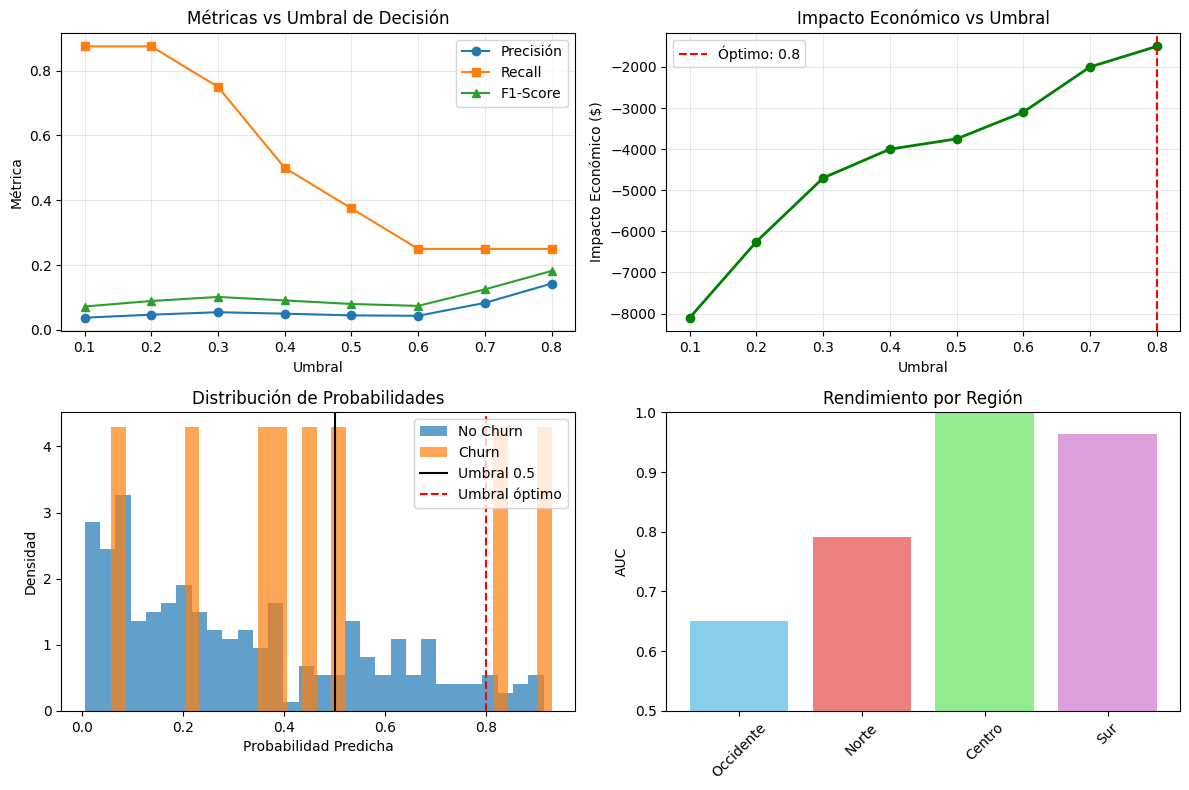

In [26]:
print("\n⚖️ DIMENSIÓN 5: CONSIDERACIONES ÉTICAS Y DE NEGOCIO")
print("="*50)

# Análisis de equidad por región
print("📊 ANÁLISIS DE EQUIDAD POR REGIÓN:")
equity_analysis = []

for region in df['region'].unique():
    region_mask = X_test['region'] == region
    if region_mask.sum() > 5:  # Suficientes muestras para análisis
        region_predictions = y_pred_proba[region_mask]
        region_actual = y_test[region_mask]

        region_auc = roc_auc_score(region_actual, region_predictions)
        region_precision = precision_score(region_actual, (region_predictions > 0.5).astype(int))
        region_recall = recall_score(region_actual, (region_predictions > 0.5).astype(int))

        equity_analysis.append({
            'region': region,
            'n_samples': region_mask.sum(),
            'auc': region_auc,
            'precision': region_precision,
            'recall': region_recall,
            'churn_rate': region_actual.mean()
        })

equity_df = pd.DataFrame(equity_analysis)
print(equity_df.round(4))

# Análisis de impacto de negocio
print(f"\n ANÁLISIS DE IMPACTO DE NEGOCIO:")
print(f"Usando un umbral de 0.5 para clasificación:")

# Calcular métricas de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Suponer costos hipotéticos
costo_fp = 50    # Costo de contactar incorrectamente a un cliente (campaña de retención innecesaria)
costo_fn = 200   # Costo de perder un cliente que haría churn
beneficio_tp = 150  # Beneficio de retener exitosamente a un cliente
costo_tn = 0     # No hay costo por clasificar correctamente a un cliente que se quedará

impacto_total = (tp * beneficio_tp) + (tn * costo_tn) - (fp * costo_fp) - (fn * costo_fn)
impacto_sin_modelo = -(y_test.sum() * costo_fn)  # Todos los churns serían pérdidas

print(f"Impacto económico con modelo: ${impacto_total:,.2f}")
print(f"Impacto sin modelo: ${impacto_sin_modelo:,.2f}")
print(f"Beneficio del modelo: ${impacto_total - impacto_sin_modelo:,.2f}")

# Análisis de diferentes umbrales
thresholds = np.arange(0.1, 0.9, 0.1)
threshold_analysis = []

for threshold in thresholds:
    pred_threshold = (y_pred_proba >= threshold).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, pred_threshold).ravel()

    impacto_t = (tp_t * beneficio_tp) + (tn_t * costo_tn) - (fp_t * costo_fp) - (fn_t * costo_fn)

    threshold_analysis.append({
        'threshold': threshold,
        'precision': precision_score(y_test, pred_threshold),
        'recall': recall_score(y_test, pred_threshold),
        'f1': f1_score(y_test, pred_threshold),
        'impacto_economico': impacto_t
    })

threshold_df = pd.DataFrame(threshold_analysis)
optimal_threshold = threshold_df.loc[threshold_df['impacto_economico'].idxmax(), 'threshold']

print(f"\n UMBRAL ÓPTIMO DESDE PERSPECTIVA DE NEGOCIO:")
print(f"Umbral óptimo: {optimal_threshold:.1f}")
print(f"Máximo impacto económico: ${threshold_df['impacto_economico'].max():,.2f}")

plt.figure(figsize=(12, 8))

# Subplot 1: Métricas vs Umbral
plt.subplot(2, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'o-', label='Precisión')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 's-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], '^-', label='F1-Score')
plt.xlabel('Umbral')
plt.ylabel('Métrica')
plt.title('Métricas vs Umbral de Decisión')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Impacto Económico vs Umbral
plt.subplot(2, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['impacto_economico'], 'o-', color='green', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Óptimo: {optimal_threshold:.1f}')
plt.xlabel('Umbral')
plt.ylabel('Impacto Económico ($)')
plt.title('Impacto Económico vs Umbral')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Distribución de Probabilidades
plt.subplot(2, 2, 3)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Churn', density=True)
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Churn', density=True)
plt.axvline(x=0.5, color='black', linestyle='-', label='Umbral 0.5')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Umbral óptimo')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Densidad')
plt.title('Distribución de Probabilidades')
plt.legend()

# Subplot 4: Equidad por Región
plt.subplot(2, 2, 4)
regions = equity_df['region']
aucs = equity_df['auc']
plt.bar(regions, aucs, color=['skyblue', 'lightcoral', 'lightgreen', 'plum'])
plt.ylabel('AUC')
plt.title('Rendimiento por Región')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()


## 7. Resumen Ejecutivo del Rendimiento


In [27]:
print("\n📋 RESUMEN EJECUTIVO - EVALUACIÓN INTEGRAL DEL MODELO DE CHURN")
print("="*70)

print(f"""
 RENDIMIENTO GENERAL:
   • AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f} - {'Excelente' if roc_auc_score(y_test, y_pred_proba) > 0.8 else 'Bueno' if roc_auc_score(y_test, y_pred_proba) > 0.7 else 'Aceptable'}
   • F1-Score: {f1_score(y_test, y_pred):.4f}
   • Precisión: {precision_score(y_test, y_pred):.4f}
   • Recall: {recall_score(y_test, y_pred):.4f}

️ ROBUSTEZ Y GENERALIZACIÓN:
   • Validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
   • Estabilidad: {'Alta' if cv_scores.std() < 0.05 else 'Media' if cv_scores.std() < 0.1 else 'Baja'}

 IMPACTO DE NEGOCIO:
   • Beneficio económico estimado: ${impacto_total - impacto_sin_modelo:,.2f}
   • Umbral óptimo de decisión: {optimal_threshold:.1f}
   • ROI del modelo: {((impacto_total - impacto_sin_modelo) / abs(impacto_sin_modelo) * 100):,.1f}%

️ CONSIDERACIONES ÉTICAS:
   • Equidad entre regiones: {'Aceptable' if equity_df['auc'].std() < 0.1 else 'Requiere atención'}
   • Sesgo detectado: {'Mínimo' if equity_df['auc'].std() < 0.05 else 'Moderado'}
""")



📋 RESUMEN EJECUTIVO - EVALUACIÓN INTEGRAL DEL MODELO DE CHURN

 RENDIMIENTO GENERAL:
   • AUC-ROC: 0.6689 - Aceptable
   • F1-Score: 0.0800
   • Precisión: 0.0448
   • Recall: 0.3750

️ ROBUSTEZ Y GENERALIZACIÓN:
   • Validación cruzada: 0.7298 ± 0.1369
   • Estabilidad: Baja

 IMPACTO DE NEGOCIO:
   • Beneficio económico estimado: $-2,150.00
   • Umbral óptimo de decisión: 0.8
   • ROI del modelo: -134.4%

️ CONSIDERACIONES ÉTICAS:
   • Equidad entre regiones: Requiere atención
   • Sesgo detectado: Moderado



## 8. Predicción para Nuevos Clientes (Ejemplo Práctico)


In [28]:
# Ejemplo de aplicación práctica del modelo
nuevos_clientes = pd.DataFrame([
    {
        "tenure_meses": 2,
        "tarifa_mensual": 229,
        "horas_uso_semana": 3,
        "dispositivos_vinculados": 2,
        "tickets_soporte_90d": 2,
        "autopago": 0,
        "recibio_promo": 0,
        "region": "Sur"
    },
    {
        "tenure_meses": 18,
        "tarifa_mensual": 149,
        "horas_uso_semana": 14,
        "dispositivos_vinculados": 4,
        "tickets_soporte_90d": 0,
        "autopago": 1,
        "recibio_promo": 1,
        "region": "Occidente"
    }
])

prob_churn = model.predict_proba(nuevos_clientes)[:, 1]
pred_churn_optimal = (prob_churn >= optimal_threshold).astype(int)

print("\n🔮 PREDICCIONES PARA NUEVOS CLIENTES:")
print("="*50)
for i, (p, c) in enumerate(zip(prob_churn, pred_churn_optimal), start=1):
    riesgo = "Alto" if p > 0.7 else "Medio" if p > 0.3 else "Bajo"
    accion = "Contactar inmediatamente" if c == 1 else "Monitorear"
    print(f"Cliente {i}:")
    print(f"  • Probabilidad de churn: {p:.3f}")
    print(f"  • Riesgo: {riesgo}")
    print(f"  • Decisión (umbral {optimal_threshold:.1f}): {accion}")
    print()

print(" RECOMENDACIONES FINALES:")
print("*"*50)
print("1. Implementar el umbral óptimo identificado para maximizar ROI")
print("2. Priorizar clientes con probabilidades entre 0.3-0.8 para campañas de retención")
print("3. Monitorear continuamente el rendimiento del modelo en producción")
print("4. Establecer alertas automáticas para detectar degradación del modelo")
print("5. Revisar periódicamente la equidad del modelo entre diferentes regiones")



🔮 PREDICCIONES PARA NUEVOS CLIENTES:
Cliente 1:
  • Probabilidad de churn: 0.943
  • Riesgo: Alto
  • Decisión (umbral 0.8): Contactar inmediatamente

Cliente 2:
  • Probabilidad de churn: 0.015
  • Riesgo: Bajo
  • Decisión (umbral 0.8): Monitorear

 RECOMENDACIONES FINALES:
**************************************************
1. Implementar el umbral óptimo identificado para maximizar ROI
2. Priorizar clientes con probabilidades entre 0.3-0.8 para campañas de retención
3. Monitorear continuamente el rendimiento del modelo en producción
4. Establecer alertas automáticas para detectar degradación del modelo
5. Revisar periódicamente la equidad del modelo entre diferentes regiones
